In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup as bs
from urllib.request import urlopen
from datetime import datetime
import pandas as pd
import numpy as np
import re
from unicodedata import normalize
import requests
import pandas as pd
import numpy as np
import time
from IPython.core.display import HTML
import pickle
import random
import matplotlib.pyplot as plt
import seaborn as sn
from functools import reduce


In [2]:
n = ['Roberto Perez', 'Yadier Molina', 'Victor Caratini', 'Willson Contreras',
 'Christian Vazquez', 'Eric Hosmer', 'Hunter Dozier', 'Josh Bell',
 'DJ LeMahieu', 'Luke Voit', 'Derek Dietrich', 'Javier Baez',
 'Jose Altuve', 'Manny Machado', 'Francisco Lindor', 'Didi Gregorius',
 'Carlos Correa', 'Matt Chapman', 'Eddie Rosario', 'Christian Yelich',
 'Nick Markakis', 'Bryce Harper', 'Adam Jones', 'Jason Heyward', 'Lorenzo Cain'
    ]
## note that they have the same order
t = ['CLE', 'STL', 'CHC', 'CHC', 'BOS', 'SD', 'KC', 'PIT', 'NYY', 'NYY', 'CIN', 'CHC', 'HOU', 'SD', 'CLE', 'NYY',
 'HOU', 'OAK', 'MIN', 'MIL', 'ATL', 'PHI', 'ARI', 'CHC', 'MIL'
    ]
### all mlb teams
club_shorts= ['col','nyy', 'sd', 'chc', 'bos', 'bal', 'phi','pit',
              'chw','tb','kc','cle','tor', 'det', 'stl', 'cin',
              'wsh','atl','tex', 'hou', 'oak','min', 'mil',
              'ari', 'laa', 'sea', 'mia', 'lad', 'nym', 'sf']

In [3]:
def soup_maker(url):
    
    """
    url: 'str'
        takes the url of the page
    return:
    pageSoup: soup object
    """
    headers = {'User-Agent': 
           'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/47.0.2526.106 Safari/537.36'}
    
    page = url
    
    pageTree = requests.get(page, headers=headers,timeout=5)
    
    pageSoup = bs(pageTree.content, 'lxml')
    
    return pageSoup

def read_games(tables):
    """
    for each player read_games will return a players game logs for a given year.
    This data already scraped with soup_maker function. 
    tables: soup object
    
    output:
    games: list of dictionaries. Each dictionary represents a game.
    """
    colhead = []
    games = []
    gameday ={}
    for table in tables:
        if 'regular season games' in table.text.lower():
            colhead_tds = table.findAll('tr', {'class': 'colhead'})[0].findAll('td')
            for td in colhead_tds:
                colhead.append(td.text)
            evenrows = table.findAll('tr', {'class': 'evenrow'})
            for evenrow in evenrows:        
                if not 'bi' in evenrow['class']:
                    cells = evenrow.findAll('td')
                    for name,cell in zip(colhead,cells):
                        gameday[name] = cell.text
                    games.append(gameday)
                    gameday = {}
            oddrows = table.findAll('tr', {'class': 'oddrow'})
            for oddrow in oddrows:
                if not 'bi' in oddrow['class']:
                    cells = oddrow.findAll('td')
                    for name,cell in zip(colhead,cells):
                        gameday[name] = cell.text
                    games.append(gameday)
                    gameday = {} 
    return games

def player_records(year = '2019', player_id = '32127'):
    """
    Given a year and player_id player_records activated read_games function by passing 
    the soup object of the relevant webpage.
    returns: 
    games: From read_games- this is a list of dictionaries.
    """
    url = 'http://www.espn.com/mlb/player/gamelog/_/id/{}/year/{}'.format(player_id, year)
    soup = soup_maker(url)
    tables = soup.findAll('table', {'class':'tablehead mod-player-stats'})
    return read_games(tables)

In [4]:
def club_rosters(url, club):
    """
    Given a baseball club url in espn 
    this functions returns its players and the link to this player
    game logs. 
    url: string type
    club: string type
    """
    player_list = []
    player_info = {}
    soup= soup_maker(url)
    for a in soup.findAll('td', {'class': 'Table2__td'}):
        hrefs = a.findAll('a', href = True)
        for link in hrefs:
            if link.text:
                name = link.text.lower().split()
                player_info['full_name'] = link.text.lower()
                player_info['name'] = name[0]
                player_info['last_name'] = name[-1]
                if len(name[1:])>1:
                    player_info['middle_name'] = name[1:-1]
                player_info['link'] = link['href']
                player_info['id'] = link['href'].split('/')[-1]
                player_info['club'] = club
                player_list.append(player_info)
                player_info = {}
    return player_list

In [5]:
def mlb_players(club_list):
    """
    Uses club_roster function to get player list from multiple clubs
    input
    club_list: list of strings.
    returns
    df: dataframe of players from given list of clubs. columns are 
    'id', 'name', 'url' etc.
    """
    rosters = []
    for name in club_list:
        url = 'https://www.espn.com/mlb/team/roster/_/name/{}'.format(name)
        rosters += club_rosters(url, name)
        df = pd.DataFrame(rosters)
    return df

In [6]:
def player_stats(player_list, club_list, years):
    """
    Given list of players and list of clubs and year this function returns
    given players all game logs in that given year.
    first we used mlb_players and then returned the result of player_records
    player_list: list of strings
    club_list: list of strings
    years: list of strings
    returns
    
    """
    data = {}
    rosters = mlb_players(club_list)
    for year in years:
        data[year] = {}
        for player in player_list:
            player= player.lower()
            if not rosters[rosters.full_name == player].empty:
                player_id = rosters[rosters.full_name ==player]['id'].values[0]
                data[year][player] = player_records(player_id=player_id, year = year)
            else:
                print('Player is not found:', player)
                continue
    return data

In [361]:
# dict_19 = player_stats(n, t, years = ['2019'])

## add injured players into the data

# molina = player_records(year = '2019', player_id = '5986')
# contreras = player_records(year = '2019', player_id = '32532')
# correa = player_records(year = '2019', player_id = '32653')
#hicks = player_records(year = '2019', player_id = '31253')
#dict_19['2019']['aaron hicks'] = hicks
# dict_19['2019']['carlos correa'] = correa
# dict_19['2019']['willson contreras'] = contreras
# dict_19['2019']['yadier molina'] = molina
#pickle.dump(dict_19, open("game_logs_2019_07_20.dict", "wb" ) )

## same for the 2018 data

# dict_18 = player_stats(n, t, years = ['2018'])
# molina = player_records(year = '2018', player_id = '5986')
# contreras = player_records(year = '2018', player_id = '32532')
# correa = player_records(year = '2018', player_id = '32653')

# dict_18['2018']['carlos correa'] = correa
# dict_18['2018']['willson contreras'] = contreras
# dict_18['2018']['yadier molina'] = molina

#pickle.dump(data, open('game_logs_2018.dict', 'wb') )



In [7]:
with open(r"game_logs_2019_07_20.dict", "rb") as input_file:
       dict_19 = pickle.load(input_file)

In [8]:
def fantasy_points(game):
    points = int(game['BB']) + 2*int(game['2B']) + 3*int(game['3B']) +\
        4*int(game['HR']) + int(game['R']) + int(game['RBI']) + \
        int(game['SB']) - int(game['CS'])  + int(game['H']) -\
         int(game['HR']) - int(game['2B']) - int(game['3B']) 
    return points



def distributions(data, player, year):
    player_data ={}
    player_data['name'] = player
    player_data['year'] = year
    player = player.lower()
    games = data[year][player]
    scores = []
    for game in games:
        try:
            score = fantasy_points(game)
            scores.append(score)
        except:
            continue
    player_data['scores'] = scores
    return player_data


def teams_to_players(list_of_players):
    d ={}
    players = [i.lower() for i in list_of_players]
    name_team = zip(n,t)
    lst = [(i.lower(), j.lower()) for i,j in name_team if i.lower() in players]
    Output = {} 
    for x, y in lst: 
        if y in Output: 
            Output[y].append(x) 
        else: 
            Output[y] = [x] 
  
    return Output

In [65]:
def logs_with_scores(player_list):
    records = {}
    dfs = []
    for player in player_list:
        player = player.lower()
        game_logs = []
        for game in dict_19['2019'][player]:
            try:
                score = fantasy_points(game)
                game['score'] = score
                game['player'] = player
                game_logs.append(game)
            except:
                continue
        records[player] = pd.DataFrame(game_logs)
        
    dfs = [pd.DataFrame(b) for a,b in records.items()]
    return dfs

In [10]:
def merge_dataframes(list_of_dataframes):
    n = len(list_of_dataframes)
    if n ==1:
        return list_of_dataframes[0][['score']]
    name_list =[]
    score_index = []
    for m in list_of_dataframes:
        name_list.append(m.player.unique()[0].split()[-1])
    df = list_of_dataframes[0]
    for i in range(n-1):
        df = df.merge(right = list_of_dataframes[i+1], on='DATE', how = 'inner', suffixes=('', '_'+ name_list[i+1]))
        score_index.append('score''_'+ name_list[i+1])
    
    return df[score_index]

In [302]:
def game_simulator(players, k = 50, threshold =20):
    scores = []
    t = np.zeros(k)
    dc = teams_to_players(players)
    for l in dc.values():
        df_list = logs_with_scores(l)
        merged_df = merge_dataframes(df_list)
        samples = merged_df.sample(k, replace=True)
        scores.append(samples.apply(sum, axis=1).values)
    for s in scores:
        t += s
    p = (t >threshold).sum()/len(s)
    print('variance of sim:%.2f'%(np.std(t)))
    print('mean of sim: %.2f'%(np.mean(t)))
    print('probability of getting a score higher than threshold: %.2f'%(p))

    return t, p

In [307]:
line_up = ('Javier Baez', 'Yadier Molina','Josh Bell', 'DJ LeMahieu',
     'Francisco Lindor', 'Manny Machado', 'Bryce Harper',
     'Christian Yelich', 'Eddie Rosario')
line_up2 = ('Eric Hosmer', 'Willson Contreras', 
            'Josh Bell', 'DJ LeMahieu', 'Javier Baez', 'Francisco Lindor',
           'Eddie Rosario', 'Christian Yelich', 'Lorenzo Cain')
s, p =game_simulator(players=line_up4, k= 500, threshold=28)

variance of sim:10.21
mean of sim: 30.75
probability of getting a score higher than threshold: 0.53


In [153]:
line_up3 = ('Luke Voit', 'Willson Contreras', 
            'Josh Bell', 'DJ LeMahieu', 'Javier Baez', 'Eddie Rosario',
           'Manny Machado', 'Christian Yelich', 'Nick Markasis')

In [308]:
line_up05_24 = ('Francisco Lindor', 'Willson Contreras', 
            'Josh Bell', 'DJ LeMahieu', 'Javier Baez', 'Eddie Rosario',
           'Manny Machado', 'Bryce Harper', 'Carlos Correa')
s, p =game_simulator(players=line_up05_24, k= 500, threshold=28)

variance of sim:10.24
mean of sim: 30.61
probability of getting a score higher than threshold: 0.52


variance of sim:9.27
mean of sim: 26.34
probability of getting a score higher than threshold: 0.23


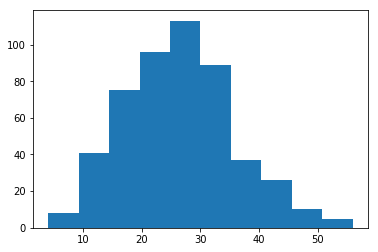

In [340]:
line_up05_25 = ('Eric Hosmer', 'Willson Contreras', 
            'Josh Bell', 'DJ LeMahieu', 'Javier Baez', 'Nick Markakis',
           'Manny Machado', 'Bryce Harper', 'Carlos Correa')
s, p =game_simulator(players=line_up05_25, k= 500, threshold=32)
plt.hist(s)
plt.show()

variance of sim:10.73
mean of sim: 30.89
probability of getting a score higher than threshold: 0.33


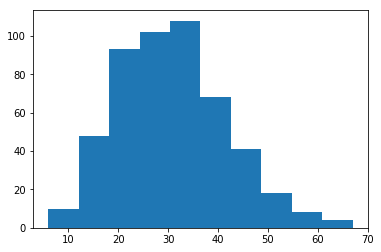

In [339]:

line_up05_26 = ('Eddie Rosario', 'Willson Contreras', 
            'Josh Bell', 'DJ LeMahieu', 'Javier Baez', 'Nick Markakis',
           'Manny Machado', 'Christian Yelich', 'Carlos Correa')
s, p =game_simulator(players=line_up05_26, k= 500, threshold=34)
plt.hist(s)
plt.show()

variance of sim:11.00
mean of sim: 32.46
probability of getting a score higher than threshold: 0.93


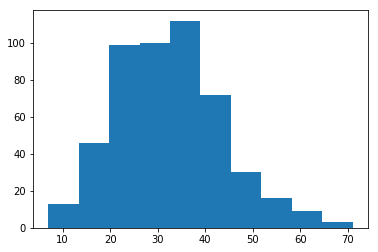

In [338]:
line_up05_31 = ('Hunter Dozier', 'Willson Contreras', 
            'Josh Bell', 'DJ LeMahieu', 'Javier Baez','Manny Machado',
            'Eddie Rosario','Christian Yelich', 'Bryce Harper')
s, p =game_simulator(players=line_up05_31, k= 500, threshold=17)
plt.hist(s)
plt.show()

variance of sim:9.57
mean of sim: 28.16
probability of getting a score higher than threshold: 0.50


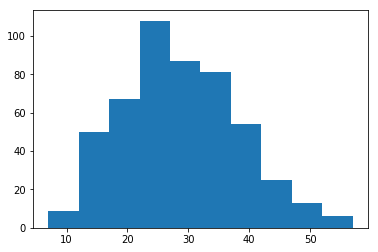

In [337]:
line_up06_01 = ('eric hosmer', 'Willson Contreras', 
            'Josh Bell', 'DJ LeMahieu', 'Javier Baez','Manny Machado',
            'Eddie Rosario','Christian Yelich', 'Bryce Harper')
s, p =game_simulator(players=line_up06_01, k= 500, threshold=27)
plt.hist(s)
plt.show()

variance of sim:10.51
mean of sim: 29.47
probability of getting a score higher than threshold: 0.52


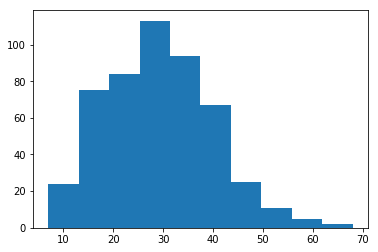

In [336]:
line_up06_02 = ('luke voit', 'Willson Contreras', 
            'Derek Dietrich', 'DJ LeMahieu', 'Matt Chapman','Francisco Lindor',
            'Eddie Rosario','Christian Yelich', 'Bryce Harper')
s, p =game_simulator(players=line_up06_02, k= 500, threshold=28)
plt.hist(s)
plt.show()

variance of sim:10.90
mean of sim: 31.11
probability of getting a score higher than threshold: 0.96


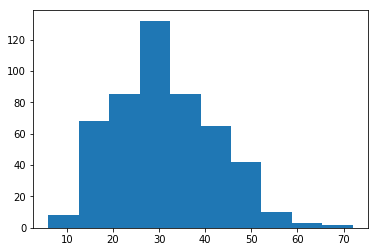

In [335]:
line_up06_07 = ('luke voit', 'Willson Contreras', 
            'Josh Bell', 'DJ LeMahieu', 'Matt Chapman','Francisco Lindor',
            'Eddie Rosario','Christian Yelich', 'Bryce Harper')
s, p =game_simulator(players=line_up06_07, k= 500, threshold=14)
plt.hist(s)
plt.show()

In [331]:
line_up06_08 = ('javier baez', 'Willson Contreras', 
            'Josh Bell', 'DJ LeMahieu', 'Matt Chapman','Francisco Lindor',
            'Eddie Rosario','Christian Yelich', 'Nick Markakis')
s, p =game_simulator(players=line_up06_08, k= 500, threshold=26)

variance of sim:9.91
mean of sim: 31.19
probability of getting a score higher than threshold: 0.63


(array([ 11.,  44., 128., 105.,  92.,  81.,  27.,   7.,   4.,   1.]),
 array([ 7. , 13.4, 19.8, 26.2, 32.6, 39. , 45.4, 51.8, 58.2, 64.6, 71. ]),
 <a list of 10 Patch objects>)

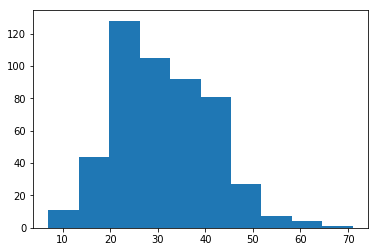

In [332]:
plt.hist(s)

variance of sim:9.68
mean of sim: 27.15
probability of getting a score higher than threshold: 0.76


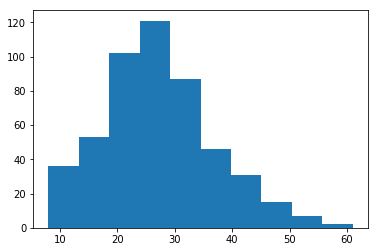

In [345]:
line_up06_09 = ('javier baez', 'Willson Contreras', 
            'Josh Bell', 'DJ LeMahieu', 'Luke Voit','Francisco Lindor',
            'Bryce Harper','Christian Yelich', 'Nick Markakis')
s, p =game_simulator(players=line_up06_09, k= 500, threshold=20)
plt.hist(s)
plt.show()

variance of sim:8.95
mean of sim: 25.72
probability of getting a score higher than threshold: 0.26


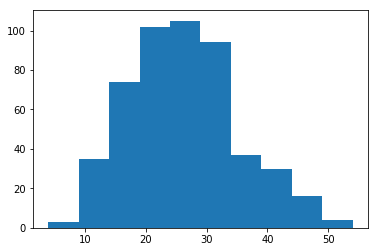

In [344]:
line_up06_14 = ('Eric Hosmer', 'Willson Contreras', 
            'Josh Bell', 'DJ LeMahieu', 'Javier Baez','Francisco Lindor',
            'Eddie Rosario','Christian Yelich', 'Lorenzo Cain')
s, p =game_simulator(players=line_up06_14, k= 500, threshold=31)
plt.hist(s)
plt.show()

variance of sim:9.72
mean of sim: 26.80
probability of getting a score higher than threshold: 0.49


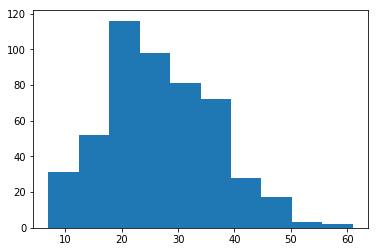

In [347]:
line_up06_15 = ('Luke Voit', 'Willson Contreras', 
            'Josh Bell', 'DJ LeMahieu', 'Javier Baez','Manny Machado',
            'Eddie Rosario','Christian Yelich', 'Nick Markakis')
s, p =game_simulator(players=line_up06_15, k= 500, threshold=26)
plt.hist(s)
plt.show()

variance of sim:11.45
mean of sim: 32.63
probability of getting a score higher than threshold: 0.47


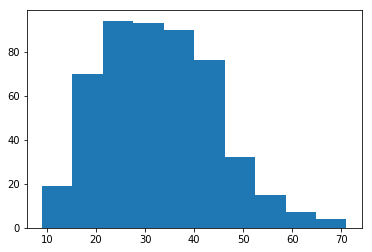

In [349]:
line_up06_16 = ('Eric Hosmer', 'Willson Contreras', 
            'Josh Bell', 'DJ LeMahieu', 'Manny Machado','Francisco Lindor',
            'Eddie Rosario','Christian Yelich', 'Bryce Harper')
s, p =game_simulator(players=line_up06_16, k= 500, threshold=32)
plt.hist(s)
plt.show()

variance of sim:10.83
mean of sim: 33.74
probability of getting a score higher than threshold: 0.35


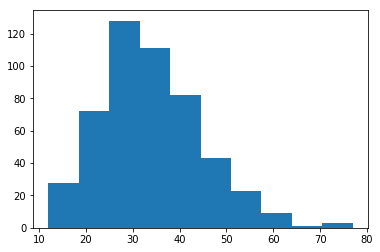

In [351]:
line_up06_21 = ('Yadier Molina', 'Bryce Harper', 
            'Josh Bell', 'DJ LeMahieu', 'Javier Baez','Manny Machado',
            'Eddie Rosario','Christian Yelich', 'Francisco Lindor')
s, p =game_simulator(players=line_up06_21, k= 500, threshold=36)
plt.hist(s)
plt.show()

variance of sim:9.06
mean of sim: 25.84
probability of getting a score higher than threshold: 0.26


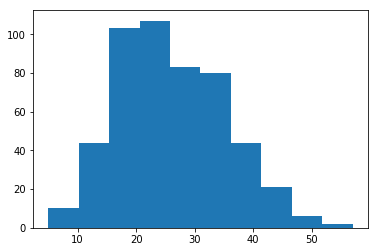

In [353]:
line_up06_22 = ('Willson Contreras', 'Bryce Harper', 
            'Josh Bell', 'DJ LeMahieu', 'Javier Baez','Manny Machado',
            'Lorenzo Cain','Christian Yelich', 'Francisco Lindor')
s, p =game_simulator(players=line_up06_22, k= 500, threshold=31)
plt.hist(s)
plt.show()

variance of sim:10.61
mean of sim: 30.23
probability of getting a score higher than threshold: 0.08


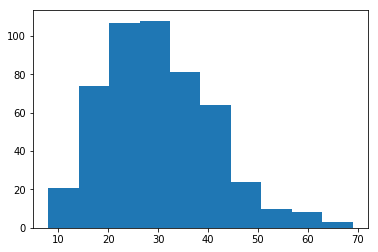

In [363]:
line_up06_23 = ('Yadier Molina', 'Bryce Harper', 
            'Josh Bell', 'Matt Chapman', 'Javier Baez','Manny Machado',
            'Jose Altuve','Christian Yelich', 'Aaron Hicks')
s, p =game_simulator(players=line_up06_23, k= 500, threshold=45)
plt.hist(s)
plt.show()

variance of sim:8.98
mean of sim: 25.49
probability of getting a score higher than threshold: 1.00


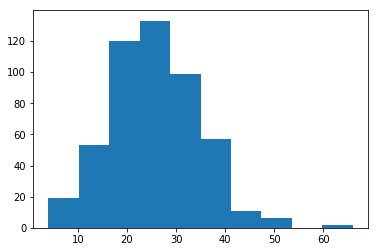

In [366]:
line_up06_28 = ('Francisco Lindor',
                'Willson Contreras',
                'Josh Bell', 
                'Javier Baez',
                'Manny Machado',
                'Jose Altuve',
                'Bryce Harper',
                'Christian Yelich',
                'Lorenzo Cain'
               )
s, p =game_simulator(players=line_up06_28, k= 500, threshold=5)
plt.hist(s)
plt.show()

variance of sim:10.31
mean of sim: 28.25
probability of getting a score higher than threshold: 0.14


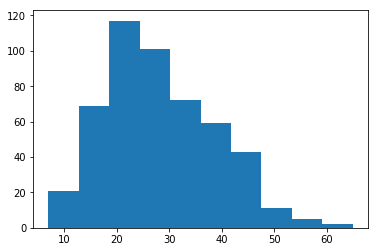

In [368]:
line_up06_29 = ('Francisco Lindor',
                'Willson Contreras',
                'Josh Bell', 
                'Jose Altuve',
                'Javier Baez',
                'DJ LeMahieu',
                'Bryce Harper',
                'Christian Yelich',
                'Aaron Hicks'
               )
s, p =game_simulator(players=line_up06_29, k= 500, threshold=40)
plt.hist(s)
plt.show()

variance of sim:9.86
mean of sim: 27.85
probability of getting a score higher than threshold: 0.08


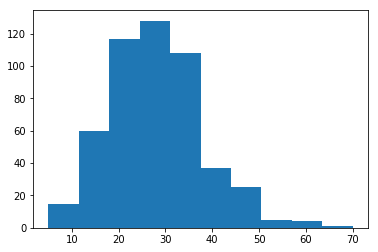

In [370]:
line_up06_30 = ('Bryce Harper',
                'Yadier Molina',
                'Josh Bell', 
                'DJ LeMahieu',
                'Javier Baez',
                'Manny Machado',
                'Lorenzo Cain',
                'Christian Yelich',
                'Nick Markakis'
               )
s, p =game_simulator(players=line_up06_30, k= 500, threshold=42)
plt.hist(s)
plt.show()

variance of sim:10.13
mean of sim: 26.13
probability of getting a score higher than threshold: 0.44


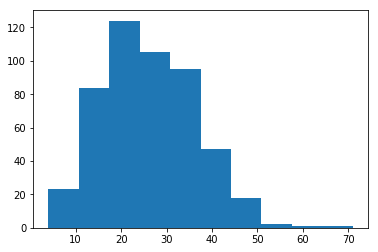

In [372]:
line_up07_05 = ('Luke Voit',
                'Yadier Molina',
                'Josh Bell', 
                'DJ LeMahieu',
                'Manny Machado',
                'Didi Gregorius',
                'Bryce Harper',
                'Christian Yelich',
                'Aaron Hicks'
               )
s, p =game_simulator(players=line_up07_05, k= 500, threshold=27)
plt.hist(s)
plt.show()

variance of sim:9.19
mean of sim: 23.68
probability of getting a score higher than threshold: 0.09


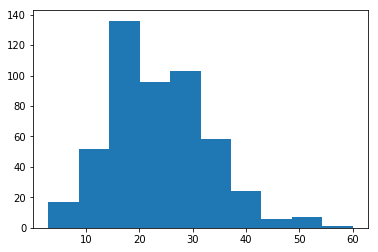

In [373]:
line_up07_06 = ('Javier Baez',
                'Willson Contreras',
                'Josh Bell', 
                'DJ LeMahieu',
                'Manny Machado',
                'Didi Gregorius',
                'Bryce Harper',
                'Christian Yelich',
                'Aaron Hicks'
               )
s, p =game_simulator(players=line_up07_06, k= 500, threshold=36)
plt.hist(s)
plt.show()

variance of sim:9.17
mean of sim: 27.77
probability of getting a score higher than threshold: 0.89


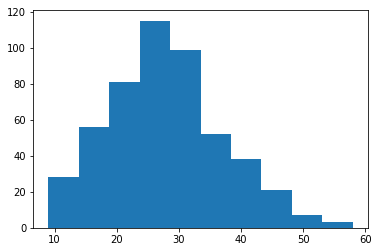

In [375]:
line_up07_07 = ('Jose Altuve',
                'Yadier Molina',
                'Josh Bell', 
                'DJ LeMahieu',
                'Javier Baez',
                'Francisco Lindor',
                'Lorenzo Cain',
                'Christian Yelich',
                'Nick Markakis'
               )
s, p =game_simulator(players=line_up07_07, k= 500, threshold=16)
plt.hist(s)
plt.show()